### Introduction

This tutorial will show how we can accurate classify audio sounds with deep learning.

Note: my internet speeds seem to greatly affect how quickly the audio data processing and feature extraction with Librosa can be. Librosa's loading speeds vary drastically. The shortest time for loading was under 6 minutes and the longest was > 1 hour. Please keep note of this. Also, the GPU wasn't always available.

###Assumptions


1.   The audio data loaded are sufficently clean and distinct between labels that the feature extraction method used is sufficient for wave pattern distinction.
2.   Librosa is the fastest audio file loader and feature extractor for this assignment. If librosa takes too long to load, you can use the preloaded **.npy** files in the shared folder using **np.load()** to the appropriate variables. For more information: https://numpy.org/doc/stable/reference/generated/numpy.load.html. The labels need to be one-hot encoded.
3.   It is appropriate to represent the audio files in a spatial/spectral context given their nature to be train a CNN.
4.   The GPU for Colab can be used for this project. If not, take out lines **with tf.device('/device:GPU:0'):** to get rid of the GPU.



### 1. Importing all the necessary modules and hardware.

There are a 5 main modules that we would be using for this particular project.  

1.   **os** - This is a Python built-in module that allows the engineer to access the local or cloud file systems.
2.   **Librosa** - Python package typically used for music and audio analysis. We are also going to be using it for feature extraction.
3.   **Numpy** - Scientific computing that will be used to process the raw audio files for deep learning.
4.   **TensorFlow** - Deep learning framework that is going to be used to build and train the CNN. 
5.   **Matplotlib** - Useful for visualization during EDA. Please use a GPU for training.




In [ ]:
import os # We are going to need os to import the .wav files into the notebook to be processed.
import numpy as np # This will be used to put the wave features of each .wav file into datasets.
import seaborn as sn # This will be used for the confusion matrix.
import pandas as pd # This will be used for the confusion matrix.
import librosa # This is the audio file processing library that I have decided to use.
from random import shuffle # This is used for shuffling the datasets once they are created.
import matplotlib.pyplot as plt # This is used during the EDA.
import tensorflow as tf # Deep learning framework used to develop the CNN for inference.

For this project, we want to use a GPU. This will help to drastically speed up training of the model. For this project, we can go to *Runtime -> Change runtime type -> Change to GPU runtime*. 

In [ ]:
# This block of code is to check if the GPU instance is running on this notebook session.
# We want to use a GPU to speed up data processing and CNN training time.

# We want to see if the Google Drive gpu is available for use in this notebook session.
# If it is available, the return on the notebook should say:
# Found GPU at: /device:GPU:0

device_name = tf.test.gpu_device_name() 
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### 2. Mounting the Google Drive to access the audio data.

For this project, we are going to use the dataset in **Dessa Cash Dataset.zip**. This contains 8732 **.wav** files. I had to unzip this file locally as I was unable to unzip the zip file directly on the Google Drive. Then, I uploaded the unzipped file onto the Google Drive. 

In this case, I created a shortcut for the data folder I unzipped and shared in the assignment drive to my main Google Drive to access it.

In [ ]:
# This script would mount the drive onto the Colab Notebook.
# If there is a drive mounted, the notebook would return:
# "Mounted at /content/drive" or 
# "Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True)."

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
AUDIO_DATASET = "/content/drive/MyDrive/Dessa_Cash_Dataset"

###3. Exploratory Data Analysis 

For EDA, we want to find out:

1.   *The label distribution in the dataset* - It is important that our dataset is reasonably balanced and that no labels are over or underrepresented.



In [ ]:
# We want to make a histogram to look at the distribution of data among the label ids.
labels = []

In [ ]:
# We want to extract all the relative paths for the audio files into a list once.
AUDIO_FILES = os.listdir(AUDIO_DATASET)
AUDIO_DATA = [audio for audio in AUDIO_FILES if audio != '.DS_Store']

In [ ]:
# Loading the array for the history:
for sound in AUDIO_DATA:  
    label = sound[-5]
    labels.append(int(label))

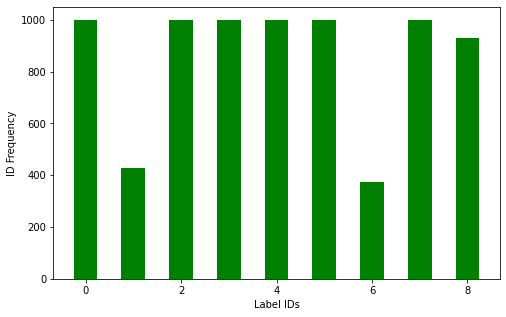

In [ ]:
# Plotting the histogram:

bins = np.arange(10)-0.5
plt.figure(figsize=(8,5))
plt.hist(labels, bins=bins, color='green', rwidth=0.5)
plt.xlabel('Label IDs')
plt.ylabel('ID Frequency')
plt.show()

Based on the information shown in the histogram, the data is generally well balanced across all label IDs. The number of samples for labels 0, 2, 3, 4, 5, 7, and 8 are around the same. However, labels 1 and 6 are underrepresented with respect to the other labels by a ratio of 2-to-1. From this, we can expect the model to underperform relative to the other classes during validation and testing. Since there is no easy way to oversample these underrepresented classes, and undersampling will eliminate most of the dataset, we will accept these shortcomings and use the dataset the way it came.

### 4. Training, Validation and Test Dataset Split

After we have done the EDA, we will now process process the audio in the .wav files and manipulate the data to prepare it for deep learning. Typically in a machine learning project, the training-validation-test split would be 80-10-10 in terms of percentages. To get this data split proportion, we extract every 9th .wav file for the validation set and every 10th .wav file for the test set within every class label. This would ensure that the distribution of the labels remain consistent throughout training, validation, and test datasets.

In [ ]:
# We want to seperate the .wav files based on label id.
label_ids = {
     0: [],
     1: [],
     2: [],
     3: [],
     4: [], 
     5: [],
     6: [],
     7: [],
     8: [],
     9: []
}

In [ ]:
def populate_id_dict():
    # This script would return a dictionary that would store the .wav file path based on their label id.
    for sound in AUDIO_DATA:  
        sound_path = os.path.join(AUDIO_DATASET, sound)
        label = sound[-5]
        label_ids[int(label)].append(sound_path)

In [ ]:
populate_id_dict()

In [ ]:
# We want to split the audio dataset into a 80-10-10 training-validation-test split.

# We want to store the file paths of the individual audio file paths for each of the 3 sub datasets.
trainset_files = [] # This is for storing paths of the training set.
validset_files = [] # This is for storing paths of the validation set.
testset_files = [] # This is for storing paths of the test set.

# We want to extract every 9th file for the validation set and every 10th for the test set
# for each label id class.
# This should distribute the data by it's class labels proportionally across all datasets.
for label, files in label_ids.items():
    for i, sound in enumerate(files):   
        if (i+1) % 10 == 9:
            validset_files.append(sound)
        elif (i+1) % 10 == 0:
            testset_files.append(sound)
        else:
            trainset_files.append(sound)

In [ ]:
# We want to shuffle the data paths for each dataset.
# This would allow faster convergence during model training.
shuffle(trainset_files)
shuffle(validset_files)
shuffle(testset_files)

###5. Data Manipulation

The purpose of the data manipulation is to prepare it for deep learning.
In this case, the Librosa library does a lot of the work extracting the amplitudes from the .wav files. We still need to set a number of features for the library to extract to be used for the model. I have decided to keep the final dataset simple and make it a 2-D array. Each row would represent single .wav file. This would also allow us to do batch SGD during training.

In [ ]:
# In accordance to standard approach, we are going to limit the number of feature measurements to 100.

FEATURE_LEN = 100

In [ ]:
def extract_label_id(sound):
    '''
    This helper function is used to extract the label of the .wav file.

    Input: the relative path of the .wav file in string type.
    Output: an integer label of the audio file.
    '''
    label_id = sound[-5]
    return int(label_id)

In [ ]:
def feature_extraction(sound_path):
    '''
    This helper function extracts the audio amplitudes and features from the .wav 
    file using Librosa. 'None' is passed in as the target_sample_rate since it 
    allows for fast loading and provides automatic normalization of the amplitudes. 
    One key detail that should be noted is that Librosa doesn't return arrays at a
    consistent length. This issue will be addressed later on. 

    The featurs that we are extracting here are the audio's Mel-Frequency Cepstral 
    Coefficients (MFCCS). These are a spectral representation of an audio clip that
    can be analyzed like an image.

    Inputs: the relative path of the .wav file in string type, and the sampling rate.
    Output: the audio file's MFCCS features in a numpy array form.
    '''

    # Audio Extraction.
    audio, sample_rate = librosa.load(sound_path, sr=None) 
    # Feature Extraction.
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=100)
    # Averging among the individua feature coefficient columns.
    mfccs_avg = np.mean(mfccs,axis=1).reshape(-1, FEATURE_LEN)
    return mfccs_avg

In [ ]:
def stack_and_concat_data(temp, audio_stack):
    '''
    This is a helper function that is used for the development of the 2-D array datasets.
    It stacks the list of feature arrays into a 2D array that can be used for 
    deep learning.

    input: temporary array for holding feature arrays and the final audio stack.
    output: the final concatenated audio stack used for DL.
    '''
    array_stack = np.stack(temp,axis=0).reshape(-1,FEATURE_LEN)
    audio_stack = np.concatenate([audio_stack, array_stack], axis=0)
    return audio_stack

In [ ]:
def concatenate_audio(audio_files):
    '''
    This function is meant to extract the audio from the .wav files and manipulate 
    them into a format that can be used for deep learning. This function has several
    key components: label id extraction, amplitude and feature extraction, and 
    concatenation. We want to batch concatenate in feature array batches of 1000 at a time. 
    This is done mainly for computation speed. The speed of the Numpy concatenation method 
    doesn't differ that much between a few and 1000 dataframes, and it's much faster to 
    do them in bulk than one at a time.

    input: relative paths for each of audio file datasets.
    output: the DL datasets and their labels.
    '''

    audio_stack = np.array([])
    audio_list = []
    audio_label = []

    # Using the GPU:
    with tf.device('/device:GPU:0'):
        # We have to iterate through all the .wav file paths to be processed.
        for audio_file in audio_files:
            # Gets the label ids of each .wav file.
            label_id = extract_label_id(audio_file)
            audio_label.append(label_id)
            # Extracts the audio features from the .wav file.
            processed_audio = feature_extraction(audio_file)
            # We use this temporary list for storing every 1000 feature
            # arrays for speed.
            audio_list.append(processed_audio)
            # We want to be able to initialize the final audio array stack dataset
            # like this due to the nature of Numpy concatenate.
            if len(audio_stack) == 0:
                print("Initializing the data stack.....")
                audio_stack = processed_audio 
            # Every 1000 arrays in the temporary list, we would concatenate it
            # to the main data stack and reset the temporary list.
            elif len(audio_list) == 1000:
                print("Adding to data stack.....")
                audio_stack = stack_and_concat_data(audio_list, audio_stack)
            # We reset the temporary list of audio arrays.
            audio_list = []
        # If the temporary list doesn't have 1000 arrays, we just concatenate the
        # remaining to the final dataset.
        audio_stack = stack_and_concat_data(audio_list, audio_stack)
        return audio_stack, audio_label

In [ ]:
# Creating the training, validation, and test datasets:
training, train_label = concatenate_audio(trainset_files)
validation, valid_label = concatenate_audio(validset_files)
test, test_label = concatenate_audio(testset_files)

In [ ]:
# We want to reshape the training, validation, and test sets to fit the dimensions of the CNN.
training, validation, test = training.reshape(len(trainset_files), FEATURE_LEN, 1), validation.reshape(len(validset_files), FEATURE_LEN, 1), test.reshape(len(testset_files), FEATURE_LEN, 1)

In [ ]:
# We also want to one hot encode the labels for all 3 datasets.
train_label = tf.keras.utils.to_categorical(train_label)
valid_label = tf.keras.utils.to_categorical(valid_label)
test_label = tf.keras.utils.to_categorical(test_label)

We also want to check the dimensions of all the datasets that we have created.

In [ ]:
print(training.shape)
print(validation.shape)
print(test.shape)

(6988, 100, 1)
(873, 100, 1)
(871, 100, 1)


In [ ]:
print(train_label.shape)
print(valid_label.shape)
print(test_label.shape)

(6988, 10)
(873, 10)
(871, 10)


### 6. Baseline Model

We want to start off with a baseline model. The baseline model should be simple to interpret and train. We have decided to go with a CNN. We chose a CNN because it is commonly used audio processing. A CNN also has the advantage of being able to capture the unique features of a particular class. In this case, it would be feature patterns at certain areas of the array.

The baseline model will have 4 convolution layers. The number of filters are 128, 64, 64, and 32. We chose these numbers as it is common to be using filter numbers of 32, 64, 128 and so on initially as default. After each convolution layer, we add a size 4 1D max pooling layer. These max pooling layers are for capturing key amplitude features within the audio arrays for distinct features. Padding is added before each convolution layer if needed for the kernels. All parameters within the layers are Xavier Glorot initialized to prevent gradient explosion or vanishing. L2 Regularization of the standard 0.01 was added to prevent overfitting. A final connected layer was added after the convolution layers as a final processing layer before the softmax classification at the end.

In [ ]:
def baseline():
    baseline = tf.keras.models.Sequential()
    # First Convolution Layer.
    baseline.add(tf.keras.layers.Conv1D(128,
                 input_shape=[100,1],
                 kernel_size=5,
                 strides=2,
                 padding='same',
                 kernel_initializer='glorot_uniform'))
    # Second Convolution Layer.
    baseline.add(tf.keras.layers.Conv1D(64,
                 kernel_size=4,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform'))
    # Third Convolution Layer.
    baseline.add(tf.keras.layers.Conv1D(64,
                 kernel_size=4,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform'))
    # Last Convolution Layer.
    baseline.add(tf.keras.layers.Conv1D(32,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform'))
    baseline.add(tf.keras.layers.Reshape((1600,)))
    # Final softmax layer for final classification over 10 classes.
    baseline.add(tf.keras.layers.Dense(10, activation='softmax'))
    return baseline

In [ ]:
batchsize = 128  # Batch size: the standard batch sizes are 64, 128, 256. We want to start somewhere in the middle so we can adjust.
epochs = 30 # We can set the number of epochs to train for to be 30 for now.
l_r = 1e-03  # Learning rate: the learning rate is usually logarithmically changed between 1e-07 to 0.1. 0.001 seems to be a good place to start.

optimizer = tf.keras.optimizers.Adam(learning_rate = l_r) # Adam is computational efficient and requires little memory.
ce_loss = tf.keras.losses.categorical_crossentropy # This is a good loss metric for multiple one-hot encoded classes.
accuracy_metric = tf.keras.metrics.CategoricalAccuracy() # This is a good accuracy metric for multiple one-hot encoded classes.

In [ ]:
baseline = baseline() # Compiling the model.
baseline.compile(optimizer=optimizer, loss=ce_loss, metrics=[accuracy_metric])

In [ ]:
# Checking the parameters of the model.
baseline.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 50, 128)           768       
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 50, 64)            32832     
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 50, 64)            16448     
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 50, 32)            6176      
_________________________________________________________________
reshape_7 (Reshape)          (None, 1600)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                16010     
Total params: 72,234
Trainable params: 72,234
Non-trainable params: 0
__________________________________________________

In [ ]:
from keras.callbacks import ReduceLROnPlateau # This is used to adjust learning rate.

In [ ]:
# This is a callback that reduces the learning rate by a factor of half if the validation accuracy doesn't increase within 5 epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5, min_lr=0.0000001, verbose=1)

# Commences training of the model.
with tf.device('/device:GPU:0'):
    history = baseline.fit(x=training, y=train_label, batch_size=batchsize, epochs=epochs,
                           validation_data=(validation, valid_label), 
                           shuffle=True, initial_epoch=0, callbacks=[reduce_lr])

# We want a place to store the training and validation loss and accuracy.
training_loss = history.history['loss']
training_accuracy = history.history['categorical_accuracy']
valid_loss = history.history['val_loss']
valid_accuracy = history.history['val_categorical_accuracy']

Epoch 1/30
55/55 [==============================] - 6s 96ms/step - loss: 3.0347 - categorical_accuracy: 0.3134 - val_loss: 1.2410 - val_categorical_accuracy: 0.5991
Epoch 2/30
55/55 [==============================] - 5s 89ms/step - loss: 1.1784 - categorical_accuracy: 0.6167 - val_loss: 1.1793 - val_categorical_accuracy: 0.6289
Epoch 3/30
55/55 [==============================] - 5s 90ms/step - loss: 1.0929 - categorical_accuracy: 0.6486 - val_loss: 1.1532 - val_categorical_accuracy: 0.6300
Epoch 4/30
55/55 [==============================] - 5s 87ms/step - loss: 1.0767 - categorical_accuracy: 0.6494 - val_loss: 1.1184 - val_categorical_accuracy: 0.6529
Epoch 5/30
55/55 [==============================] - 5s 87ms/step - loss: 1.0272 - categorical_accuracy: 0.6690 - val_loss: 1.1422 - val_categorical_accuracy: 0.6174
Epoch 6/30
55/55 [==============================] - 5s 88ms/step - loss: 1.0172 - categorical_accuracy: 0.6731 - val_loss: 1.1305 - val_categorical_accuracy: 0.6289
Epoch 7/30

We seem to have a proper baseline model for experimentation at this point. The training accuracy seems to have reached a relatively high accuracy within 30 epochs, finalizing at 72.98%. However, the validation accuracy has plateaued between 63% to 68% early on at around 5 epochs. Thie clearly shows that the model is overfitting. We will discuss how to mitigate these problems in the next section. 

### 7. Improvement Models

To mitigate overfitting, we are going to apply L2 regularization on  each convolution layer and ReLu activation after each convolution layer to help reduce overfitting. This should allow the validation accuracy to progress and keep up with the training accuracy.

In [ ]:
def model1():
    model1 = tf.keras.models.Sequential()
    # First Convolution Layer.
    model1.add(tf.keras.layers.Conv1D(128,
                 input_shape=[100,1],
                 kernel_size=5,
                 strides=2,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
    # ReLu activation added.
    model1.add(tf.keras.layers.Activation('relu'))
    # Second Convolution Layer.
    model1.add(tf.keras.layers.Conv1D(64,
                 kernel_size=4,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
    # ReLu activation added.
    model1.add(tf.keras.layers.Activation('relu'))
    # Third Convolution Layer.
    model1.add(tf.keras.layers.Conv1D(64,
                 kernel_size=4,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
    # ReLu activation added.
    model1.add(tf.keras.layers.Activation('relu'))
    # Last Convolution Layer.
    model1.add(tf.keras.layers.Conv1D(32,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
    # ReLu activation added.
    model1.add(tf.keras.layers.Activation('relu'))
    model1.add(tf.keras.layers.Reshape((1600,)))
    # Final softmax layer for final classification over 10 classes.
    model1.add(tf.keras.layers.Dense(10, activation='softmax'))
    return model1

In [ ]:
# We need to reset the optimizer, loss function, and accuracy metric for each model.
optimizer = tf.keras.optimizers.Adam(learning_rate = l_r) # Adam is computational efficient and requires little memory.
ce_loss = tf.keras.losses.categorical_crossentropy # This is a good loss metric for multiple one-hot encoded classes.
accuracy_metric = tf.keras.metrics.CategoricalAccuracy() # This is a good accuracy metric for multiple one-hot encoded classes.

In [ ]:
model1 = model1() # Compiling the model.
model1.compile(optimizer=optimizer, loss=ce_loss, metrics=[accuracy_metric])

In [ ]:
model1.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 50, 128)           768       
_________________________________________________________________
activation_8 (Activation)    (None, 50, 128)           0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 50, 64)            32832     
_________________________________________________________________
activation_9 (Activation)    (None, 50, 64)            0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 50, 64)            16448     
_________________________________________________________________
activation_10 (Activation)   (None, 50, 64)            0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 50, 32)           

In [ ]:
# This is a callback that reduces the learning rate by a factor of half if the validation accuracy doesn't increase within 5 epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5, min_lr=0.0000001, verbose=1)

# Commences training of the model.
with tf.device('/device:GPU:0'):
    history_2 = model1.fit(x=training, y=train_label, batch_size=batchsize, epochs=epochs,
                           validation_data=(validation, valid_label), 
                           shuffle=True, initial_epoch=0, callbacks=[reduce_lr])

# We want a place to store the training and validation loss and accuracy.
training_loss = history_2.history['loss']
training_accuracy = history_2.history['categorical_accuracy']
valid_loss = history_2.history['val_loss']
valid_accuracy = history_2.history['val_categorical_accuracy']

Epoch 1/30
55/55 [==============================] - 6s 95ms/step - loss: 3.6214 - categorical_accuracy: 0.3539 - val_loss: 2.3327 - val_categorical_accuracy: 0.6312
Epoch 2/30
55/55 [==============================] - 5s 91ms/step - loss: 2.1012 - categorical_accuracy: 0.6832 - val_loss: 1.8262 - val_categorical_accuracy: 0.7068
Epoch 3/30
55/55 [==============================] - 5s 89ms/step - loss: 1.6035 - categorical_accuracy: 0.7653 - val_loss: 1.5174 - val_categorical_accuracy: 0.7617
Epoch 4/30
55/55 [==============================] - 5s 90ms/step - loss: 1.3543 - categorical_accuracy: 0.8116 - val_loss: 1.3270 - val_categorical_accuracy: 0.8064
Epoch 5/30
55/55 [==============================] - 5s 91ms/step - loss: 1.1843 - categorical_accuracy: 0.8355 - val_loss: 1.1812 - val_categorical_accuracy: 0.8202
Epoch 6/30
55/55 [==============================] - 5s 88ms/step - loss: 1.0388 - categorical_accuracy: 0.8604 - val_loss: 1.1508 - val_categorical_accuracy: 0.8144
Epoch 7/30

This improved version of the neural network was able to deliver much faster converge and significantly better results in both training and validation accuracy, reaching 97.50% and 89.92% respectively. 

We hope to increase the performance of the neural network by adding a 1D max pooling layer between each convolution layer and a fully connected layer after the convolutions. This theoretically should allow the model to reduce noise and dimensionality of the data in between convolutions and make finding distinctive patterns easier.

In [ ]:
def model2():
    model2 = tf.keras.models.Sequential()
    # First Convolution Layer.
    model2.add(tf.keras.layers.Conv1D(128,
                 input_shape=[100,1],
                 kernel_size=5,
                 strides=2,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
    model2.add(tf.keras.layers.Activation('relu'))
    # Adding a max pooling layer to reduce noise and dimensionality.
    model2.add(tf.keras.layers.MaxPooling1D(pool_size=2, strides=1))
    # Second Convolution Layer.
    model2.add(tf.keras.layers.Conv1D(64,
                 kernel_size=4,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
    model2.add(tf.keras.layers.Activation('relu'))
    # Adding a max pooling layer to reduce noise and dimensionality.
    model2.add(tf.keras.layers.MaxPooling1D(pool_size=2, strides=1))
    # Third Convolution Layer.
    model2.add(tf.keras.layers.Conv1D(64,
                 kernel_size=4,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
    model2.add(tf.keras.layers.Activation('relu'))
    # Adding a max pooling layer to reduce noise and dimensionality.
    model2.add(tf.keras.layers.MaxPooling1D(pool_size=2, strides=1))
    # Last Convolution Layer.
    model2.add(tf.keras.layers.Conv1D(32,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
    model2.add(tf.keras.layers.Activation('relu'))
    # Adding a max pooling layer to reduce noise and dimensionality.
    model2.add(tf.keras.layers.MaxPooling1D(pool_size=2, strides=1))
    model2.add(tf.keras.layers.Reshape((1472,)))
    # Adding a fully connected layer to help with pattern recognition.
    model2.add(tf.keras.layers.Dense(1000, activation='relu', 
                                     kernel_initializer='glorot_uniform',
                                     bias_initializer='zeros'))
    model2.add(tf.keras.layers.Dropout(0.2))
    # Final softmax layer for final classification over 10 classes.
    model2.add(tf.keras.layers.Dense(10, activation='softmax'))
    return model2

In [ ]:
# We need to reset the optimizer, loss function, and accuracy metric for each model.
optimizer = tf.keras.optimizers.Adam(learning_rate = l_r) # Adam is computational efficient and requires little memory.
ce_loss = tf.keras.losses.categorical_crossentropy # This is a good loss metric for multiple one-hot encoded classes.
accuracy_metric = tf.keras.metrics.CategoricalAccuracy() # This is a good accuracy metric for multiple one-hot encoded classes.

In [ ]:
model2 = model2() # Compiling the model.
model2.compile(optimizer=optimizer, loss=ce_loss, metrics=[accuracy_metric])

In [ ]:
model2.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_44 (Conv1D)           (None, 50, 128)           768       
_________________________________________________________________
activation_20 (Activation)   (None, 50, 128)           0         
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 49, 128)           0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 49, 64)            32832     
_________________________________________________________________
activation_21 (Activation)   (None, 49, 64)            0         
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 48, 64)            0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 48, 64)          

In [ ]:
# This is a callback that reduces the learning rate by a factor of half if the validation accuracy doesn't increase within 5 epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5, min_lr=0.0000001, verbose=1)

# Commences training of the model.
with tf.device('/device:GPU:0'):
    history_3 = model2.fit(x=training, y=train_label, batch_size=batchsize, epochs=epochs,
                           validation_data=(validation, valid_label), 
                           shuffle=True, initial_epoch=0, callbacks=[reduce_lr])

# We want a place to store the training and validation loss and accuracy.
training_loss = history_3.history['loss']
training_accuracy = history_3.history['categorical_accuracy']
valid_loss = history_3.history['val_loss']
valid_accuracy = history_3.history['val_categorical_accuracy']

Epoch 1/30
55/55 [==============================] - 9s 145ms/step - loss: 3.8598 - categorical_accuracy: 0.3222 - val_loss: 2.4140 - val_categorical_accuracy: 0.6483
Epoch 2/30
55/55 [==============================] - 10s 177ms/step - loss: 2.2151 - categorical_accuracy: 0.6999 - val_loss: 1.9353 - val_categorical_accuracy: 0.7090
Epoch 3/30
55/55 [==============================] - 8s 148ms/step - loss: 1.6945 - categorical_accuracy: 0.7761 - val_loss: 1.4973 - val_categorical_accuracy: 0.7995
Epoch 4/30
55/55 [==============================] - 8s 137ms/step - loss: 1.3272 - categorical_accuracy: 0.8453 - val_loss: 1.3173 - val_categorical_accuracy: 0.8190
Epoch 5/30
55/55 [==============================] - 7s 136ms/step - loss: 1.0994 - categorical_accuracy: 0.8850 - val_loss: 1.1112 - val_categorical_accuracy: 0.8683
Epoch 6/30
55/55 [==============================] - 7s 136ms/step - loss: 0.9119 - categorical_accuracy: 0.9174 - val_loss: 1.0080 - val_categorical_accuracy: 0.8660
Epo

We are now getting very high validation accuracy with our model at 93.70%. The training accuracy is now at a peak of 99.88%. It can be said that the max pooling and final fully connected layer are successful at feature distinction between label IDs.

One thing that should be noted is that we didn't use batch normalization after each convolution layer. Batch normalization is most commonly used to decrease the covariance shift of the output between convolutions to make the model converge faster. However, since the model begin converging very fast at 9 epochs, this doesn't seem necessary.

### 8. Inference

Finally, we want to see how well the model performs on the test dataset that we created.

#### Testing Set Accuracy

In [ ]:
# Testing out the model on the test set.
test_pred = model2.predict(test)
accuracy = tf.keras.metrics.CategoricalAccuracy()
accuracy.update_state(test_label, test_pred)
accuracy = accuracy.result().numpy()

In [ ]:
# Printing the test accuracy:
accuracy

0.946039

The test dataset has produced 94.60% accuracy.

#### Confusion Matrix

It would also very interesting to see how different classes in the test dataset performed.

In [ ]:
test_label_decoded = tf.math.argmax(test_label, axis=1)
test_pred_decoded = tf.math.argmax(test_pred, axis=1)

In [ ]:
# Creating the numbers for the confusion matrix.
confusion_matrix = tf.math.confusion_matrix(test_label_decoded, test_pred_decoded)

In [ ]:
confusion_matrix

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[97,  0,  0,  0,  1,  0,  0,  0,  0,  2],
       [ 0, 40,  0,  0,  1,  0,  0,  0,  0,  1],
       [ 1,  0, 92,  2,  1,  1,  1,  0,  2,  0],
       [ 1,  0,  2, 91,  1,  0,  1,  0,  3,  1],
       [ 0,  0,  1,  0, 93,  0,  0,  2,  1,  3],
       [ 0,  0,  1,  0,  0, 97,  0,  0,  1,  1],
       [ 0,  0,  2,  1,  0,  0, 34,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0, 99,  0,  0],
       [ 1,  0,  0,  2,  1,  0,  0,  0, 88,  0],
       [ 1,  2,  2,  0,  0,  2,  0,  0,  0, 93]], dtype=int32)>

[Text(69.0, 0.5, 'Ground Truth Label'), Text(0.5, 42.0, 'Predictions')]

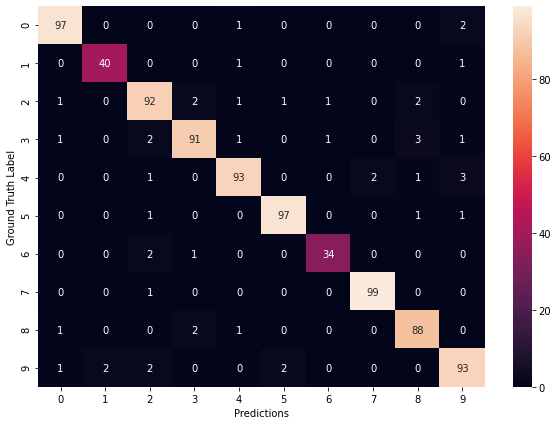

In [ ]:
# Printing the confusion matrix.
df_cm = pd.DataFrame(np.array(confusion_matrix), index = [i for i in range(10)],
                                       columns = [i for i in range(10)])
plt.figure(figsize = (10,7))
heatmap = sn.heatmap(df_cm, annot=True)
heatmap.set(xlabel='Predictions', ylabel='Ground Truth Label')

It can be said that the CNN model has performed very well across all classes. One detail that should be noted is that classes 1 and 6 seemed to underperform a little bit relative to the other classes. This is likely due to the dataset imbalance that was present in the dataset in the beginning.

### 8. Conclusion

This concludes this project. It is fair to say that we have succeeded at producing a model that can accurately classify sounds.

If given more time and hardware resources, we can experiment more with how batch size, batch normalization, and different optimizers affect model performance on the validation and testing set. It would also be insightful to experiment more with model architecture and different types of models for time, such as LSTMs and Feed Forward Neural Networks. Lastly, I am interested in training the model for more epochs to see how the model behaves the more it trains.